# Extended Kalman Filter(EKF) for GPS triangulation

This is a simple implementation of an Extended Kalman Filter for GPS triangulation. The filter is implemented in Python and tested with simulated data. The filter is able to estimate the position and velocity of a moving object given the GPS measurements with a certain accuracy.

## State Definition
The state of the system is defined as follows:
$$
\begin{align}
\mathbf{x} &= \begin{bmatrix} x \\ \dot{x} \\ y \\ \dot{y} \\ z \\ \dot{z} \\ cdt \\ c\dot{dt}\end{bmatrix}
\end{align}
$$
where $x,y,z$ are the position of the object in the ECEF frame, $v_x,v_y,v_z$ are the velocity of the object in the ECEF frame, $cdt$ is the reciever clock bias and $c\dot{dt}$ is the reciever clock drift in units of meters.

## State transition function:
Assuming constant velocity model, the state transition function $F$ can be calculated by using the unit time step model:
$$
A = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}
$$
Now the state transition function can be calculated as:
$$
F = \begin{bmatrix} A & 0 & 0 & 0 \\ 0 & A & 0 & 0 \\ 0 & 0 & A & 0 \\ 0 & 0 & 0 & A \end{bmatrix}
$$
which is and 8x8 matrix which maps the state at time $t$ to the state at time $t+1$.

## Process noise
The continuous time process noise matrix $Q$ is defined as:
$$
Q = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt
$$
where $Q_c$ is the continuous process noise matrix. This is the projection of the continuous noise onto the discrete time model. Defining $Q_c$ as:
$$
Q_c = \begin{bmatrix} 0 & 0 \\ 0 & 1  \end{bmatrix} \cdot \Phi_{B}^2
$$
where $\Phi_{B}$ is the spectral density of the process noise.

Now we can project the continuous time process noise onto the discrete time model:
$$
Q_p = \int_{0}^{\Delta t} F(t)Q_cF^T(t) dt = \begin{bmatrix} \frac{1}{3}\Delta t^3 & \frac{1}{2}\Delta t^2 \\ \frac{1}{2}\Delta t^2 & \Delta t \end{bmatrix} \cdot \Phi_{B}^2
$$
The clock covariance can be modelled by a random walk process defined by $S_p$ the white noise spectral density leading to random walk velocity error, and $S_g$ the white noise spectral density leading to random walk clock drift error. The process noise matrix $Q_c$ is then defined as:
$$
Q_c = \begin{bmatrix} S_f \Delta t +\frac{S_g\Delta t^3}{3}, S_g\frac{\Delta t^2}{2} \\ S_g\frac{\Delta t^2}{2} , S_g \Delta t  \end{bmatrix}
$$

So the final process noise matrix $Q$ is defined as:
$$
Q = \begin{bmatrix} Q_p, 0, 0, 0 \\ 0, Q_p, 0, 0 \\ 0, 0, Q_p, 0 \\ 0, 0, 0, Q_c \end{bmatrix}
$$

## Measurement covariance
The measurement covariance matrix is defined to be a diagonal matrix with uncorrected standard deviation $\sigma_r$ of the measurements. The measurement covariance matrix is defined as:
$$
R = \begin{bmatrix} \sigma_r^2, 0, 0 , 0 \\ 0, \sigma_r^2, 0 , 0\\ 0, 0, \sigma_r^2 ,0 \\  0, 0, 0, \sigma_r^2 \end{bmatrix}
$$
where $\sigma_r$ is the standard deviation of the pseudorange measurements. 

# The Measurement function
The measurement function $h$ to convert the state to the measurement space. To convert the state vector to the measurement space, we need to calculate the distance between the reciever and the GPS satellites plus the reciever clock offset error. Hence, the measurement function $h$ is defined as:
$$
h(x_s , s_i) = \sqrt {(x_s - x_i)^2 + (y_s - y_i)^2 + (z_s - z_i)^2} + cdt
$$
This is a non-linear function and hence a non-linear filter is required to estimate the state of the system.

In [1]:
%load_ext autoreload
%autoreload 2
from navigator.epoch import Epoch, from_rinex_files, EpochCollection
from pathlib import Path


obsPath = Path("data/JPLM00USA_R_20223230000_01D_30S_MO.crx.gz")
navPath = Path("data/JPLM00USA_R_20223230000_01D_GN.rnx.gz")

epoches = list(from_rinex_files(
    observation_file=obsPath,
    navigation_file=navPath,
    profile=Epoch.DUAL
))

Processing 2022-11-19 23:59:30: 100%|██████████| 2880/2880 [00:05<00:00, 512.96it/s]


Since these are the collection of continouos epoches, we wrap the list of the Epoches into an epoches collection.

In [2]:
collection = EpochCollection(
    epochs=epoches,
)

Not to run the EKF, we need a continuoius visiblily of the tracked satellites. This continuous visiblity allows us to run the extended kalman filter to filter the states.

In [3]:
ctg0 = collection.track(mode=EpochCollection.VISIBILITY)[0]

Let's create a extended kalman filtering interface which can be used to estimate the PVT state of the reciever.

In [4]:
from navigator.core import  ExtendedKalmanInterface, Triangulate, IterativeTriangulationInterface
import numpy as np

# Define the state dimension and measurement dimension
DIM_STATE = 8
DIM_MEASUREMENT = len(ctg0[0]) # Length of the satellites in first epoch

# Define the initial state
x0 = np.zeros(DIM_STATE)
P0 = np.eye(DIM_STATE) * 1e5

# Define the process noise
Q = np.eye(DIM_STATE) * 1e-6
R = np.eye(DIM_MEASUREMENT) * 64


# Define the Iterative Triangulation Interface to compare with the EKF
tri_wls = Triangulate(
    interface=IterativeTriangulationInterface(

    )
)
# Define the Extend Kalman Interface
eki = ExtendedKalmanInterface(
    dt=30.0, # This data is in 30s interval
    num_sv=DIM_MEASUREMENT, # Number of satellites
    x0=x0, # Prior state
    P0=P0, # Prior covariance
    R=R, # Measurement noise
    Q_0=Q, # Process noise
    log_innovation=True, # Log the innovation
    code_only=True  # Use only the code measurements

)

Now let's preprocess the tensors to computational format i.e range_measurements, satellite positions which will apply all the preprocessing given in epoch profile

In [5]:
z, sv_pos = eki.epoches_to_timeseries(
    epoches=ctg0,
)

Now, we can use the interface fixed_interval_smoothing to perform a filtering and smoothing to get the PVT states of the reciever.

In [14]:
state, resudials = eki.fixed_interval_smoothing(
    x0=x0,
    P0=P0,
    z=z,
    sv_pos=sv_pos,
)

Let's plot the autocorreleation function of the residuals to see if the residuals to see the filter behaviour,

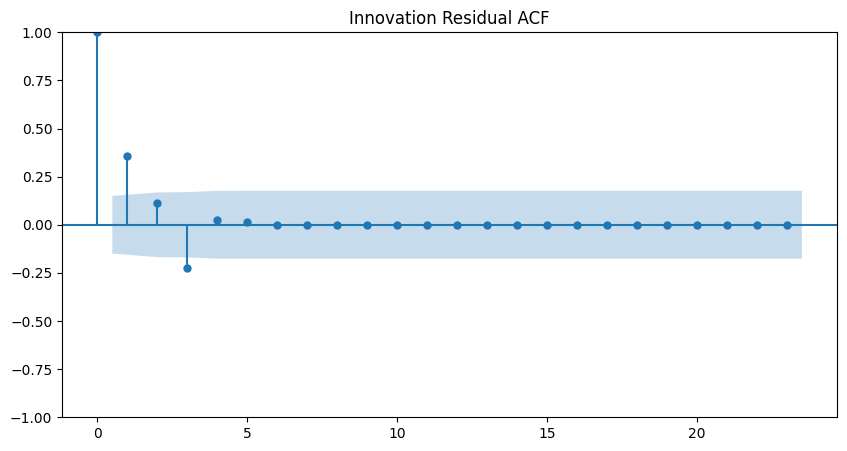

In [24]:
# Import plot afc function
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

afc_plot , ax = plt.subplots(1, 1, figsize=(10, 5))

plot_acf(
    x=resudials["innovation_residual"][:, 0], ax=ax
);

ax.set_title("Innovation Residual ACF");


To compare, let us triangulate the epoches with WLS,

In [15]:
df = tri_wls.triangulate_time_series(epoches=ctg0)

Triangulating:   0%|          | 0/171 [00:00<?, ?it/s]

Triangulating: 100%|██████████| 171/171 [00:13<00:00, 12.93it/s]


Since, this is an IGS station, we can get the exact coordinate of the station and see the error asscoiated with our prediction. 

In [17]:
import pandas as pd

realCoords = pd.DataFrame(
    data=Epoch.IGS_NETWORK.get_xyz(station="JPLM00USA").reshape(1,-1).repeat(len(ctg0), axis=0),
    columns=["x", "y", "z"]
)

Let's calculate the ENU error associated with two triangulation methods:

In [18]:
from navigator.core import  Triangulate


enuError_EKF = Triangulate.enu_error(
    predicted=state,
    actual=realCoords
)
enuError_WLS = Triangulate.enu_error(
    predicted=df,
    actual=realCoords
)

Seperate the ENU error after filter convergence,

In [19]:
enuConvgEKF  = enuError_EKF[30:]
enuConvgWLS = enuError_WLS[30:]

Let's see the error statistics

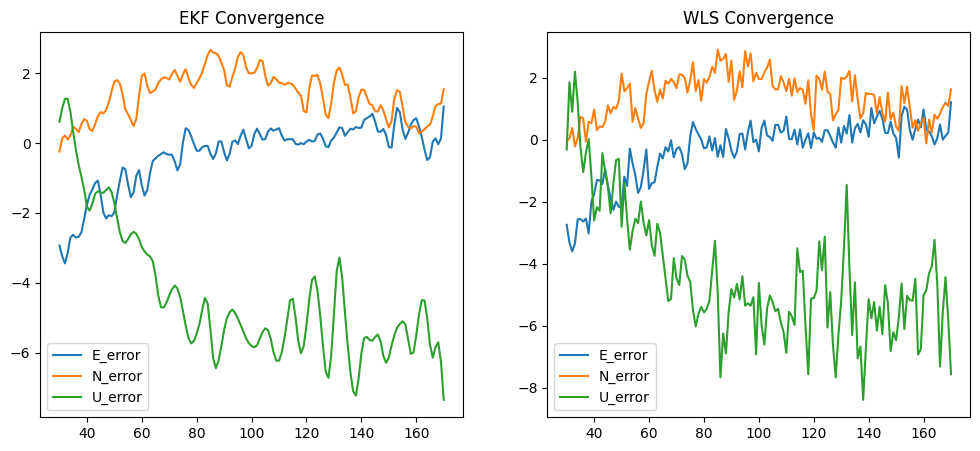

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


enuConvgEKF.plot(ax=ax[0], title="EKF Convergence");
enuConvgWLS.plot(ax=ax[1], title="WLS Convergence");

As one can see there is substantial reduction in the variance of the measurements from EKF compared to WLS. Now let's calculate the total error

In [30]:
ekfTotalError = enuConvgEKF.apply(np.linalg.norm, axis=1)
wlsTotalError = enuConvgWLS.apply(np.linalg.norm, axis=1)

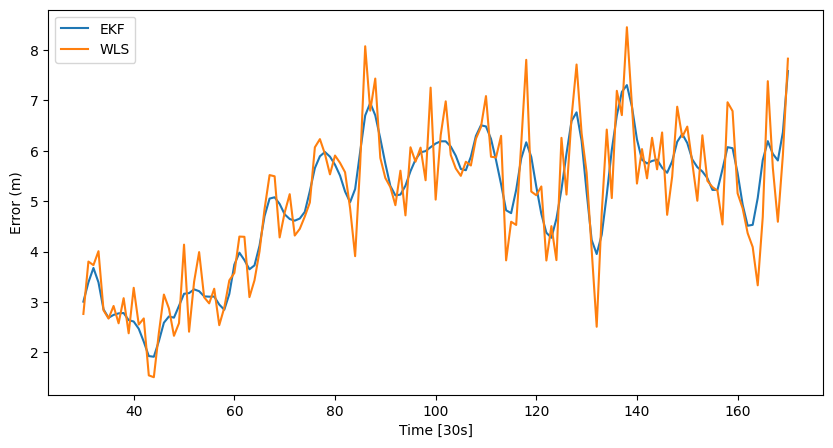

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


error_fig, error_ax = plt.subplots(1, 1, figsize=(10, 5))


# Plot the total error
sns.lineplot(
    x=enuConvgEKF.index,
    y=ekfTotalError,
    ax=error_ax,
    label="EKF"
)

sns.lineplot(
    x=enuConvgWLS.index,
    y=wlsTotalError,
    ax=error_ax,
    label="WLS"
)
# Add the labels
error_ax.set_xlabel("Time [30s]")
error_ax.set_ylabel("Error (m)")

# Save the figure
plt.savefig("error.png")

Let's see the histogram of the velocity plots to see the velocity predictions.

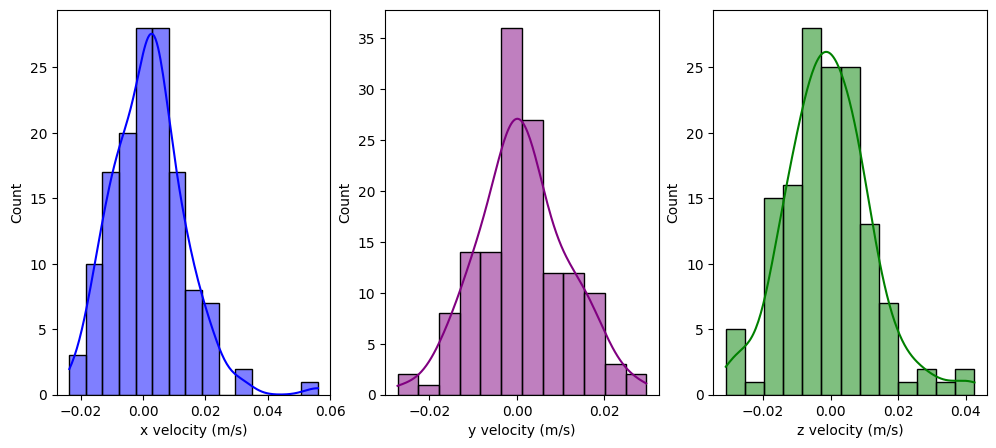

In [53]:
vel_fig, ax = plt.subplots(1, 3, figsize=(12, 5))


sns.histplot(
    x=state["x_dot"].iloc[30:],
    ax=ax[0],
    kde=True,
    color="blue"
)

sns.histplot(
    x=state["y_dot"].iloc[30:],
    ax=ax[1],
    kde=True,
    color="purple"
)

sns.histplot(
    x=state["z_dot"].iloc[30:],
    ax=ax[2],
    kde=True,
    color="green"
)

# Label the axis
ax[0].set_xlabel("x velocity (m/s)")
ax[1].set_xlabel("y velocity (m/s)")
ax[2].set_xlabel("z velocity (m/s)")


# Save the figure
plt.savefig("velocity.png")